# Gradient Descent and Logistic Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
import ipywidgets

plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [12, 8]
mpl.rcParams['animation.html'] = 'jshtml'

# Minimizing Univariate Functions

Let's try to minimize this function:

In [2]:
def f(x):
    return np.exp(x) - 100*x**2

Here is the plot of $f$:

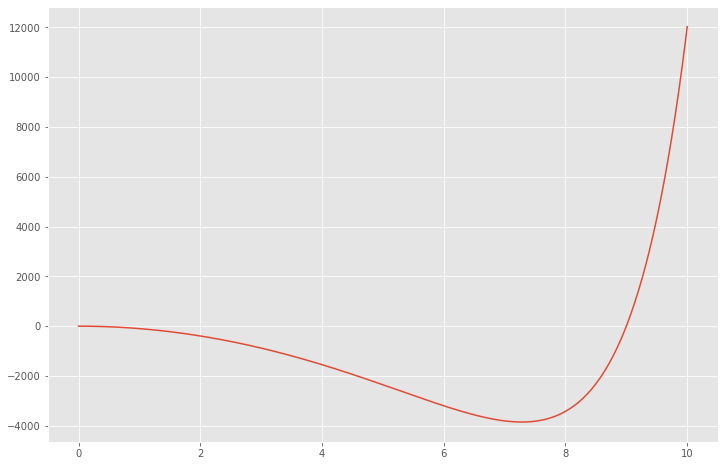

In [3]:
x = np.linspace(0, 10, 1000)
plt.plot(x, f(x))

It looks like the minimizer is around $x = 7$. Let's try to find it using calculus. Here is there derivative of $f$:

In [4]:
def f_prime(x):
    return np.exp(x) - 200*x

We can't simply set $f' = 0$ and solve for $x$; we won't get an explicit solution. Instead, let's use gradient descent. Here is the algorithm (with some extra options provided for convenience):

In [5]:
def gradient_descent(
        derivative_of_f, *, h_0, alpha, max_iter=10_000, tol=1e-12, verbose=False,
        callback=None
    ):
    """Minimize a (univariate) function f using gradient descent.
    
    Parameters
    ----------
    derivative_of_f : callable
        A function which accepts one argument, h, and outputs the derivative
        of f at h.
    h_0 : float
        The initial guess of the minimizer.
    alpha : float
        The step size parameter.
    max_iter : int
        The maximum number of steps to take.
    tol : float
        The convergence tolerance. If the difference between subsequent guesses
        is less than tol, the algorithm will assume that it has converged.
    verbose : bool
        If `True`, prints the progress of the search.
    callback : callable
        A function called after every update with the new position.
    """
    h = h_0
    for iteration in range(max_iter):
        h_next = h - alpha * derivative_of_f(h)
        if np.linalg.norm(h_next - h) < tol:
            break
        if verbose:
            print(f'iter #{iteration}: h={h_next}')
        if callback is not None:
            callback(h_next)
        h = h_next
    else:
        if verbose:
            print('Reached Max Iters')
    return h

Let's run gradient descent with a learning rate of $\alpha = .001$ until the difference between consecutive steps is smaller than $10^{-5}$.

In [6]:
gradient_descent(
    f_prime,
    h_0=4,
    alpha=.001,
    verbose=True,
    tol=.00001,
)

iter #0: h=4.745401849966855
iter #1: h=5.579428189287118
iter #2: h=6.430393748815543
iter #3: h=7.096054309726863
iter #4: h=7.30807072203524
iter #5: h=7.277389508834394
iter #6: h=7.285662237209038
iter #7: h=7.283567517174359
iter #8: h=7.284107326313366
iter #9: h=7.2839688292137605
iter #10: h=7.284004403450608


7.284004403450608

The cell below visualizes the progress of gradient descent:

In [7]:
from utils import visualize_gradient_descent

In [8]:
visualize_gradient_descent(
    f=f,
    derivative_of_f=f_prime,
    h_0=4,
    alpha=.001,
    n_iters=10,
    interval_size=2,
    domain=np.linspace(0, 10, 100),
    arrow_height=.2
)

We could have also started from the right of the minimizer:

In [9]:
visualize_gradient_descent(
    f=f,
    derivative_of_f=f_prime,
    h_0=9,
    alpha=.0001,
    n_iters=10,
    interval_size=2,
    domain=np.linspace(0, 10, 100),
    arrow_height=.2
)

But if we set the learning rate to be too large, we'll see gradient descent "bounce" out of the minimum.

In [10]:
visualize_gradient_descent(
    f=f,
    derivative_of_f=f_prime,
    h_0=2,
    alpha=.004,
    n_iters=10,
    interval_size=2,
    domain=np.linspace(0, 10, 100),
    arrow_height=.2
)

# Logistic Regression on the Heart Data Set

Now let's go back to the heart data set and perform logistic regression in order to determine whether someone has heart disease or not.

In [11]:
import sklearn.model_selection
import sklearn.preprocessing
import pandas as pd

As a reminder, here is what the data looks like. `target` is 1 if the patient has heart disease, and zero otherwise.

In [12]:
data = pd.read_csv('heart.csv')
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


We'll start by splitting the data into a training and test set, and standardizing:

In [13]:
X = data.iloc[:,:-1].copy().values
y = data.iloc[:,-1].copy().values
y[y == 0] = -1

np.random.seed(42)
train_X, test_X, train_y, test_y = sklearn.model_selection.train_test_split(X, y)

scaler = sklearn.preprocessing.StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

We'll also augment the data vectors by adding a column of all ones to `train_X` and `test_X`. Note that we do this after standardization!

In [14]:
train_X = np.column_stack((np.ones(len(train_X)), train_X))
test_X = np.column_stack((np.ones(len(test_X)), test_X))

We want to maximize the log likelihood. This is the same as running gradient descent, but walking in the direction of the gradient (instead of in the direction of the negative gradient). We can accomplish this by feeding a negative step size into `gradient_descent`.

In [15]:
def gradient_ascent(*args, **kwargs):
    kwargs['alpha'] = -kwargs['alpha']
    return gradient_descent(*args, **kwargs)

To run gradient ascent, we need the gradient of the log likelihood:

In [16]:
def sigma(t):
    return 1/(1 + np.exp(-t))

def make_gradient_of_log_likelihood(X, y):
    def gradient_of_log_likelihood(w):
        return np.sum(sigma(-y[:,None] * X @ w)[:,None] * X * y[:,None], axis=0)
    return gradient_of_log_likelihood

In [17]:
gradient_of_log_likelihood = make_gradient_of_log_likelihood(train_X, train_y)

At every step, we'll print out the current log likelihood:

In [18]:
def print_log_likelihood(w):
    print('log L:', -np.log(1 + np.exp(-train_y[:,None] * train_X @ w)).sum(axis=0))

Now we run gradient ascent:

In [19]:
w = gradient_ascent(
    gradient_of_log_likelihood,
    h_0=np.ones(14),
    alpha=.01,
    verbose=True,
    tol=.00001,
    max_iter=2000,
    callback=print_log_likelihood
)

iter #0: h=[0.91463052 0.39462758 0.41558554 1.38036303 0.5445435  0.63924503
 0.73301031 0.97459006 1.43711234 0.29277295 0.18907576 1.36503024
 0.19370048 0.2691648 ]
log L: -208.6582337536342
iter #1: h=[ 0.78230696  0.22524676  0.04047805  1.39830672  0.3046211   0.43080446
  0.5475326   0.87631375  1.36203963  0.0444309  -0.07346139  1.28565119
 -0.20321193 -0.10393427]
log L: -146.0318972377625
iter #2: h=[ 0.66147558  0.15293447 -0.22067912  1.33556274  0.12540095  0.31342408
  0.4014047   0.79629521  1.21537072 -0.07748295 -0.18032916  1.15824339
 -0.43817129 -0.32988122]
log L: -116.88536618895387
iter #3: h=[ 0.56040319  0.12174383 -0.41014956  1.25632898 -0.01964943  0.22985894
  0.29474177  0.73111271  1.06787813 -0.15385123 -0.24566065  1.04010517
 -0.5907997  -0.47282744]
log L: -100.49990109104998
iter #4: h=[ 0.47777883  0.1088084  -0.54549406  1.18143705 -0.12999108  0.16213806
  0.22092098  0.67623921  0.94000696 -0.20969145 -0.2966545   0.94132525
 -0.69415873 -0.563

Here is the parameter vector that we found:

In [20]:
w

array([ 0.15329871, -0.01622039, -0.73917646,  0.95188812, -0.23841145,
       -0.13500368,  0.03002028,  0.43396204,  0.37931614, -0.54130967,
       -0.7229986 ,  0.46562688, -0.8992735 , -0.64739685])

Remember that the prediction rule is:

$$
    H_{\vec w}(\vec x) = \sigma(\vec w \cdot \vec x)
$$

So the predicted probabilities of heart disease for the training set are:

In [35]:
sigma(train_X @ w)

array([6.56972785e-01, 7.81790296e-01, 1.27899547e-01, 3.79459686e-02,
       5.61704166e-01, 4.52501355e-02, 7.30875629e-01, 7.33546480e-01,
       7.32142424e-01, 3.04832704e-02, 4.64758156e-04, 9.38822412e-01,
       7.89644198e-01, 3.92529682e-01, 9.74011974e-01, 9.97657368e-01,
       9.33545856e-01, 9.69412364e-01, 6.84479262e-01, 5.61704166e-01,
       8.47907695e-01, 1.25594623e-01, 9.52342464e-01, 2.21307871e-01,
       6.02157419e-01, 9.94416342e-01, 8.45878240e-01, 2.15276061e-02,
       5.03657837e-01, 9.23486082e-01, 9.74166069e-01, 9.69485154e-01,
       5.73816884e-01, 1.60096716e-02, 9.84746820e-01, 9.76276550e-01,
       2.30444399e-03, 6.50588522e-01, 5.02548772e-01, 5.74608147e-01,
       2.13581317e-01, 9.79826479e-01, 6.90511643e-01, 2.25875460e-02,
       1.78167841e-01, 2.10752437e-02, 1.18577570e-02, 5.82235106e-01,
       5.28526968e-03, 7.96887152e-03, 7.70182789e-01, 6.45056670e-02,
       3.43053099e-01, 4.01279190e-01, 6.33580809e-01, 9.80748344e-01,
      

And for the test set:

In [36]:
sigma(test_X @ w)

array([8.05069024e-02, 7.22693267e-01, 8.50461940e-01, 1.39367734e-02,
       9.59253975e-01, 9.32251319e-01, 5.68815903e-01, 7.36142291e-04,
       3.40639994e-03, 4.56277249e-01, 8.22106232e-01, 6.13972134e-02,
       9.32029439e-01, 2.36381653e-02, 9.92132718e-01, 9.50158972e-01,
       9.89422065e-01, 7.72921398e-02, 5.15966710e-03, 7.95676917e-03,
       6.84358486e-01, 7.26261836e-03, 2.51520260e-01, 8.24859039e-01,
       9.62298233e-01, 6.74276722e-01, 9.26912522e-01, 4.91858199e-01,
       4.29594362e-03, 9.35723064e-01, 3.52155255e-02, 1.89741685e-02,
       5.21422849e-03, 6.00989720e-02, 8.52257812e-01, 4.53216708e-02,
       6.54914907e-01, 8.95011004e-01, 8.30059198e-01, 8.14195182e-01,
       5.08771476e-01, 8.05572821e-01, 8.38895205e-01, 7.05185475e-01,
       8.64599865e-01, 2.46385902e-03, 8.06648446e-01, 9.62017599e-01,
       6.27069587e-02, 1.27855832e-02, 3.67190012e-02, 4.66102785e-03,
       9.25124907e-01, 9.87725112e-01, 1.30203067e-01, 6.02991954e-04,
      

For which patients is the probability > $1/2$?

In [41]:
predictions = sigma(test_X @ w) > .5
predictions

array([False,  True,  True, False,  True,  True,  True, False, False,
       False,  True, False,  True, False,  True,  True,  True, False,
       False, False,  True, False, False,  True,  True,  True,  True,
       False, False,  True, False, False, False, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False, False, False, False,  True,  True,
       False, False, False,  True, False, False, False,  True, False,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True])

These are the classifications for the test set. How well do we do? `test_y` contains the right answers:

In [42]:
ground_truth = test_y == 1
ground_truth

array([False, False,  True, False,  True,  True,  True, False, False,
        True,  True,  True,  True, False,  True,  True,  True, False,
       False, False,  True, False, False,  True,  True, False, False,
        True, False,  True,  True, False, False,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True, False, False, False, False,  True,  True,
       False, False, False,  True, False, False, False,  True, False,
       False,  True, False,  True,  True,  True, False,  True,  True,
       False,  True, False,  True])

In [43]:
predictions == ground_truth

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False,  True,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True,  True])

In [44]:
(predictions == ground_truth).mean()

0.8552631578947368

So we have performed at about 85% accuracy. Not bad!